# 12-Car Multi-Vehicle Simulation

This notebook simulates a 12-car platoon where:
- Car 0 is the **lead vehicle** with a prescribed speed profile.
- Cars 1–11 are followers.
- **3 cars** use the **wead controller** (our custom controller).
- **9 cars** use the **profacc controller** (simple proportional time-gap law).

wead cars are placed at:
- Car 1 (front of the platoon, right behind the lead)
- Car 6 (middle of the platoon)
- Car 11 (last car)


In [93]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# Simulation settings
N_CARS = 12          # 0 = lead, 1..11 = followers
T_END = 60.0         # seconds
DT = 0.1             # time step [s]

time = np.arange(0.0, T_END + DT, DT)
N_STEPS = len(time)


## Controllers: wead and profacc

In [94]:
def wead_controller(sn, vn):
    """WEAD controller (my controller), ported from Simulink.

    Inputs:
        sn : space gap [m] (lead_pos - ego_pos)
        vn : ego speed [m/s]
    Returns:
        cmd_accel [m/s^2]
    """
    STOPPED_SPEED_TH = 1.0     # [m/s]
    STOPPED_MIN_GAP = 5.0      # [m]
    STOPPED_ACCEL    = 1.0     # [m/s^2]

    MAX_ACCEL = 2.5            # [m/s^2]
    MAX_BRAKE = -2.5           # [m/s^2]

    CRUISE_SPEED_LIMIT = 36.0  # [m/s]

    # State 1: stopped / very low speed
    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            cmd_accel = STOPPED_ACCEL
        else:
            cmd_accel = 0.0
    else:
        # State 2: time-gap based logic
        time_gap = sn / vn

        if time_gap <= 3.0:
            cmd_accel = MAX_BRAKE
        elif time_gap < 4.0:
            cmd_accel = (2.5 * time_gap) - 10.0
        elif time_gap <= 5.0:
            cmd_accel = 0.0
        elif time_gap < 6.0:
            cmd_accel = (2.5 * time_gap) - 12.5
        elif time_gap >= 6.0:
            if vn <= CRUISE_SPEED_LIMIT:
                cmd_accel = MAX_ACCEL
            else:
                cmd_accel = 0.0
        else:
            cmd_accel = 0.0

    return cmd_accel


def profacc_controller(sn, vn, alpha, tau):
    """ProFACC controller from Simulink:

        cmd_accel = alpha * (sn - tau * vn)

    Inputs:
        sn : space gap [m]
        vn : ego speed [m/s]
        alpha : gain
        tau : desired time gap [s]
    """
    return alpha * (sn - tau * vn)


## Lead Vehicle Speed Profile

In [95]:
def lead_speed_profile(t: float) -> float:
    """
    Lead vehicle speed [m/s] as a function of time.

    0–20 s:  20 m/s (cruise)
    20–22 s: linear ramp from 20 -> 10 m/s
    >22 s:  10 m/s (cruise)
    """
    if t < 20.0:
        return 20.0
    elif t < 22.0:
        # ramp: 20 m/s down to 10 m/s over 2 seconds
        return 20.0 - 5.0 * (t - 20.0)    # at t=20 -> 20; t=22 -> 10
    else:
        return 10.0



## State Initialization

In [96]:
# Positions and speeds: shape (time, car_index)
x = np.zeros((N_STEPS, N_CARS))
v = np.zeros((N_STEPS, N_CARS))
gap = np.zeros((N_STEPS, N_CARS))  # gap[i] = x_(i-1) - x_i

# Initial lead car
x[0, 0] = 0.0
v[0, 0] = lead_speed_profile(0.0)

# Initial followers: spaced 10 m apart, all stopped
for i in range(1, N_CARS):
    x[0, i] = -10.0 * i
    v[0, i] = 0.0


## Controller Assignment (3 wead, 9 profacc)

In [97]:
# controller_mode: 0 = lead, 1 = WEAD, 2 = profacc
controller = 2 * np.ones(N_CARS, dtype=int)
controller[0] = 0

# WEAD cars: front (1), middle (6), end (11)
wead_indices = [1, 6, 11]
for idx in wead_indices:
    controller[idx] = 1

profacc_indices = [i for i in range(1, N_CARS) if i not in wead_indices]

print('WEAD cars:    ', wead_indices)
print('ProFACC cars: ', profacc_indices)

# profacc parameters (TODO: set these to match my Simulink alpha/tau) COME BACK TO THIS
alpha_prof = 0.5   # gain
tau_prof   = 1.2   # desired time gap [s]


WEAD cars:     [1, 6, 11]
ProFACC cars:  [2, 3, 4, 5, 7, 8, 9, 10]


## Simulation Loop

In [98]:
for k in range(N_STEPS - 1):
    t = time[k]

    # Lead car (car 0): externally specified speed
    v[k, 0] = lead_speed_profile(t)
    x[k + 1, 0] = x[k, 0] + DT * v[k, 0]

    # Followers: cars 1..11
    for i in range(1, N_CARS):
        # Space gap to car ahead
        gap[k, i] = x[k, i-1] - x[k, i]
        sn = gap[k, i]
        vn = v[k, i]


        if controller[i] == 1:   # WEAD
            a = wead_controller(sn, vn)
        else:                         # ProFACC
            a = profacc_controller(sn, vn, alpha_prof, tau_prof)

        # Integrate speed and position (forward Euler) chat helped with this
        v[k + 1, i] = v[k, i] + DT * a
        x[k + 1, i] = x[k, i] + DT * v[k, i]

# Last-step gaps
for i in range(1, N_CARS):
    gap[-1, i] = x[-1, i-1] - x[-1, i]


## Plots: Speeds and Gaps

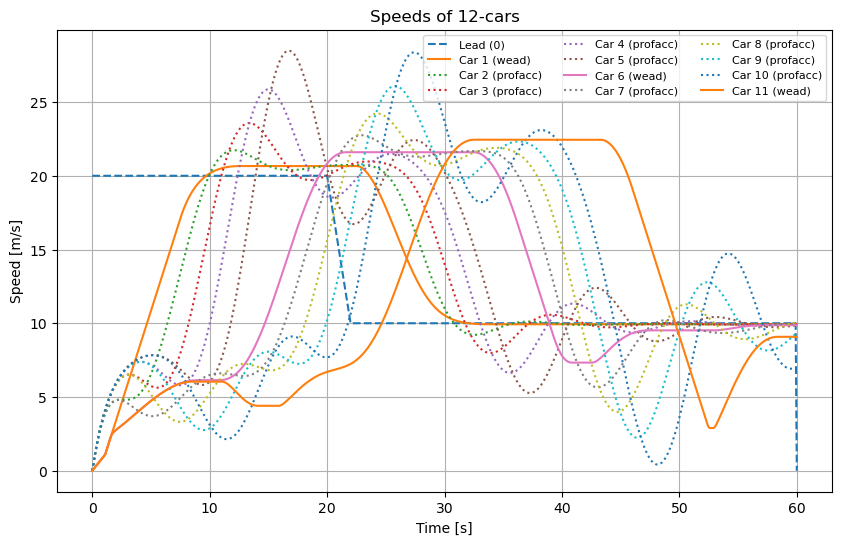

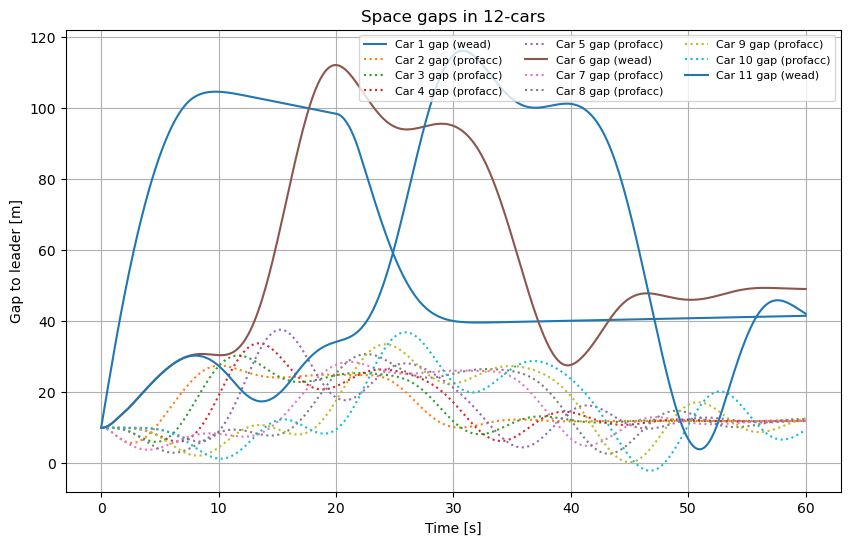

In [99]:
# Speed trajectories
plt.figure()
for i in range(N_CARS):
    if i == 0:
        style, label = '--', 'Lead (0)'
    elif controller[i] == 1:
        style, label = '-', f'Car {i} (wead)'
    else:
        style, label = ':', f'Car {i} (profacc)'

    plt.plot(time, v[:, i], style, label=label)

plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speeds of 12-cars')
plt.legend(ncol=3, fontsize=8)
plt.show()

# Gap trajectories (to car in front)
plt.figure()
for i in range(1, N_CARS):
    if controller_mode[i] == 1:
        style, label = '-', f'Car {i} gap (wead)'
    else:
        style, label = ':', f'Car {i} gap (profacc)'

    plt.plot(time, gap[:, i], style, label=label)

plt.xlabel('Time [s]')
plt.ylabel('Gap to leader [m]')
plt.title('Space gaps in 12-cars')
plt.legend(ncol=3, fontsize=8)
plt.show()


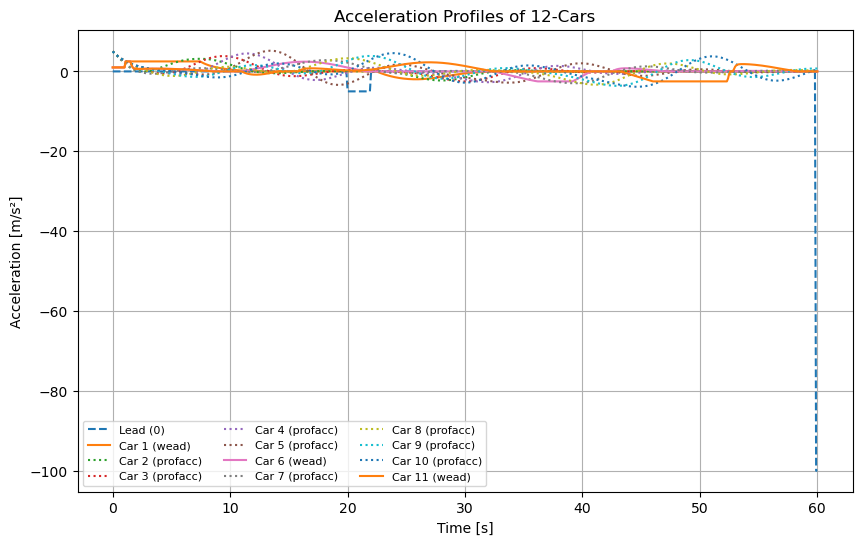

In [100]:
# acceleration computation from velocities
# a[k, i] ≈ (v[k+1, i] - v[k, i]) / DT
a = np.zeros_like(v)
a[:-1, :] = (v[1:, :] - v[:-1, :]) / DT
a[-1, :] = a[-2, :]  # copy last valid accel so shape matches

plt.figure()
for i in range(N_CARS):
    if i == 0:
        style, label = "--", "Lead (0)"
    elif controller[i] == 1:  # WEAD
        style, label = "-", f"Car {i} (wead)"
    else:                          # ProFACC
        style, label = ":", f"Car {i} (profacc)"

    plt.plot(time, a[:, i], style, label=label)

plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s²]")
plt.title("Acceleration Profiles of 12-Cars")
plt.legend(ncol=3, fontsize=8)
plt.grid(True)
plt.show()


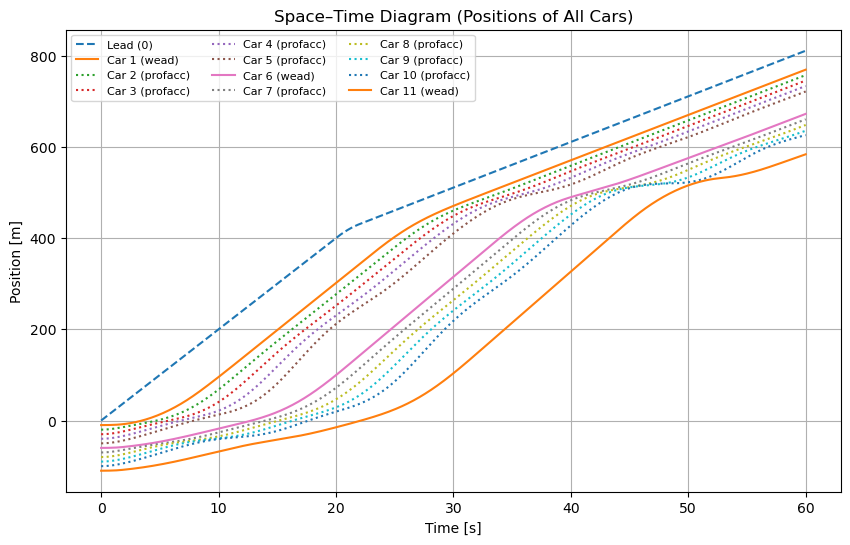

In [101]:
plt.figure()

for i in range(N_CARS):
    if i == 0:
        style, label = "--", "Lead (0)"
    elif controller[i] == 1:  # WEAD cars
        style, label = "-", f"Car {i} (wead)"
    else:
        style, label = ":", f"Car {i} (profacc)"

    plt.plot(time, x[:, i], style, label=label)

plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title("Space–Time Diagram (Positions of All Cars)")
plt.legend(ncol=3, fontsize=8)
plt.grid(True)
plt.show()
